### Import Libraries

In [1]:
import os
import cv2
import math
import time
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
random_seed = 42
torch.manual_seed(random_seed);

In [4]:
torch.set_printoptions(edgeitems=5)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()

In [7]:
device

device(type='cuda')

### Step 1a) Fetch the LFW dataset

In [15]:
main_dir = '../datasets/LFW'
data_dir = main_dir + "/lfw-deepfunneled/lfw-deepfunneled"

print(os.listdir(main_dir))
classes = os.listdir(data_dir)
print(len(classes))

['people.csv', 'lfw_readme.csv', 'pairs.csv', 'matchpairsDevTest.csv', 'lfw-deepfunneled', 'peopleDevTest.csv', 'matchpairsDevTrain.csv', 'peopleDevTrain.csv', 'mismatchpairsDevTrain.csv', 'mismatchpairsDevTest.csv', 'lfw_allnames.csv']
5749


In [16]:
img_Aaron_Eckhart = os.listdir(data_dir + "/Aaron_Eckhart")
print('No. of training examples for Aaron_Eckhart:', len(img_Aaron_Eckhart))
print(img_Aaron_Eckhart[:])

No. of training examples for Aaron_Eckhart: 1
['Aaron_Eckhart_0001.jpg']


In [17]:
dataset = ImageFolder(data_dir, transform=ToTensor())

In [18]:
len(dataset)

13233

In [21]:
print(dataset.classes)

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adelina_Avila', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrien_Brody', 'Afton_Smith', 'Agbani_Darego', 'Agn

### Step 1b) Visualize the dataset

In [19]:
img, label = dataset[13232]
print(img.shape, label)

torch.Size([3, 250, 250]) 5748


Text(0.5, 1.0, 'label = 5748')

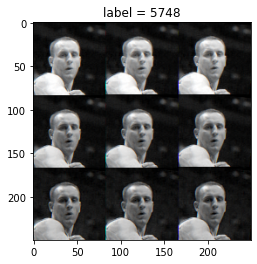

In [20]:
img, label = dataset[13232]
img = torch.reshape(img, (250, 250, 3))

plt.imshow(img)
plt.title('label = ' + str(label))

### Step 1c) Split the dataset into training, validation, and testing

In [22]:
test_factor = 0.1
test_size = int(test_factor * len(dataset))
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

val_factor = 0.1
val_size = int(val_factor * len(dataset))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [23]:
len(train_ds), len(val_ds), len(test_ds)

(10587, 1323, 1323)

In [24]:
batch_size=128

In [25]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [26]:
len(train_dl), len(val_dl), len(test_dl)

(83, 11, 11)

### Step 2a) Model Architecture - Network

In [8]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [9]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [10]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [11]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [12]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [13]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        layers = [conv_2d(3, 64, ks=7, stride=2)]
        layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten(), 
                   nn.Linear(n_channels[n_groups]*2, n_classes)]
    
        self.features = nn.Sequential(*layers)
        
    def forward(self, x):
        #a = self.features(x)
        #print(a.shape)
        return self.features(x)

In [14]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50(n_classes):
    return MyResNet(4, N_50, n_classes, k=2)

def ResNet101(n_classes):
    return MyResNet(4, N_101, n_classes, k=2)

def ResNet152(n_classes):
    return MyResNet(4, N_152, n_classes, k=2)

In [28]:
model = ResNet50(5749)

In [29]:
to_device(model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [30]:
summary(model, input_size = (3, 250, 250), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           9,408
         MaxPool2d-2           [-1, 64, 63, 63]               0
       BatchNorm2d-3           [-1, 64, 63, 63]             128
            Conv2d-4          [-1, 256, 63, 63]          16,384
            Conv2d-5           [-1, 64, 63, 63]           4,096
       BatchNorm2d-6           [-1, 64, 63, 63]             128
              ReLU-7           [-1, 64, 63, 63]               0
            Conv2d-8           [-1, 64, 63, 63]          36,864
       BatchNorm2d-9           [-1, 64, 63, 63]             128
             ReLU-10           [-1, 64, 63, 63]               0
           Conv2d-11          [-1, 256, 63, 63]          16,384
         ResBlock-12          [-1, 256, 63, 63]               0
      BatchNorm2d-13          [-1, 256, 63, 63]             512
           Conv2d-14           [-1, 64,

### Step 2b) Loss Function

In [34]:
loss_Function = F.cross_entropy #CosFace() #

### Step 3) Training the model

In [31]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    #Generate predictions
    preds = model(xb)
    #Generate probabilities
    #preds = F.softmax(preds, dim=1)
    #Calculate loss
    loss = loss_func(preds, yb)
    
    if opt is not None:
        #Compute gradients
        loss.backward()
        #update parameters
        opt.step()
        #Reset Gradients
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(preds, yb)
    
    #print(loss.is_cuda)
    #print(xb.is_cuda)
    #print(metric_result.is_cuda)
        
    return loss.item(), len(xb), metric_result

In [32]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        #Total size of the dataset
        total = np.sum(nums)
        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        
        if metric is not None:
            #Avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [33]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, metric=None, opt_fn=None):
    
    train_losses, val_losses, val_metrics = [], [], []
    
    #instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        start = time.time()
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        #Record the loss and metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        end = time.time()

        #Print progress:
        if metric is None:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))
            print(str(round((end - start), 2)) + " secs")
        
        else:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
            print(str(round((end - start), 2)) + " secs")

    return train_losses, val_losses, val_metrics

In [35]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [36]:
val_loss, _, val_acc = evaluate(model, loss_Function, val_dl, metric=accuracy) #metric=accuracy #metric=None

In [37]:
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))
#print('Loss: {:.4f}'.format(val_loss))

Loss: 8.6827, Accuracy: 0.0000


In [38]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [39]:
history = fit(num_epochs, model, loss_Function, train_dl, val_dl, lr, accuracy, opt_func)

Epoch [1/10], Train_loss: 8.3635, Val_loss: 8.2566, accuracy: 0.0438
33.65 secs
Epoch [2/10], Train_loss: 7.7693, Val_loss: 8.5588, accuracy: 0.0454
35.16 secs
Epoch [3/10], Train_loss: 7.1064, Val_loss: 8.6070, accuracy: 0.0469
34.87 secs
Epoch [4/10], Train_loss: 6.2455, Val_loss: 9.0315, accuracy: 0.0476
34.78 secs
Epoch [5/10], Train_loss: 5.6966, Val_loss: 9.8398, accuracy: 0.0378
33.64 secs
Epoch [6/10], Train_loss: 5.1785, Val_loss: 10.5188, accuracy: 0.0219
33.7 secs
Epoch [7/10], Train_loss: 4.2123, Val_loss: 11.2557, accuracy: 0.0574
33.94 secs
Epoch [8/10], Train_loss: 3.4193, Val_loss: 11.4759, accuracy: 0.0416
33.93 secs
Epoch [9/10], Train_loss: 2.5031, Val_loss: 12.2272, accuracy: 0.0408
34.37 secs
Epoch [10/10], Train_loss: 1.9904, Val_loss: 12.2486, accuracy: 0.0612
34.38 secs


### Step 4) Evaluate the model and Plotting of curves

In [40]:
train_losses, val_losses, val_metrics = history

In [41]:
def plot_accuracies(epoch, val_metrics):
    #accuracies = [x['val_metrics'] for x in history]
    x = np.arange(1, epoch+1, 1)
    plt.plot(x, val_metrics, '-x')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, epoch))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

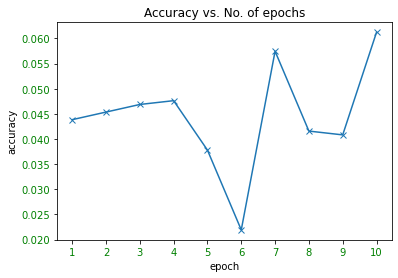

In [42]:
plot_accuracies(num_epochs, val_metrics)

In [43]:
def plot_losses(epoch, train_losses, val_losses):
    #train_losses = [x.get('train_losses') for x in history]
    #val_losses = [x['val_losses'] for x in history]
    x = np.arange(1, epoch+1, 1)
    
    plt.plot(x, train_losses, '-bx')
    plt.plot(x, val_losses, '-rx')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, epoch))
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

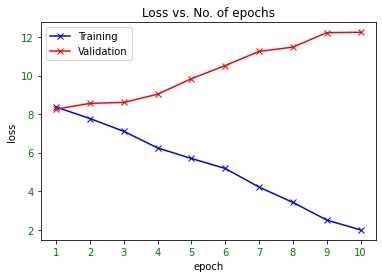

In [44]:
plot_losses(num_epochs, train_losses, val_losses)

In [45]:
result = evaluate(model, loss_Function, test_dl, accuracy)
result

(12.406018734338693, 1323, 0.06424792139077853)

In [46]:
torch.save(model.state_dict(), 'el_lfw.pth')

In [ ]:
loaded_model = ResNet50(85742)
to_device(loaded_model, device)

In [ ]:
loaded_model.load_state_dict(torch.load("training/el_13-02.pth"))

In [ ]:
for param in loaded_model.parameters():
    param.requires_grad = False
    print(param.shape)
    loaded_model.fc = nn.Linear(512, 8)